## Background

This is a data analysis for 
"Anxiety and Depression Rates Between Women with and without Endometriosis" 
presented in a 2023 poster section for CENTER FOR RESEARCH IN WOMEN’S HEALTH at Cedars Sinai

In [282]:
import seaborn as sns
import util
import pandas as pd
import numpy as np
import re
from pathlib import Path
from statannotations.Annotator import Annotator
from upsetplot import UpSet,from_memberships


## Data Import from RedCap API

In [322]:
project_name = "poster"
config_json = util.get_config_json(project_name)
table_df = util.get_data(config_json)
table_df = table_df.apply(pd.to_numeric, downcast="integer", errors="ignore").fillna(0)
data_df = util.get_data_dict()

## Extract and Recode RedCap Variables for Downstream Analysis 

In [323]:
type_detail_map = {1:"confirmed",
                   2:"confirmed",
                   3:"suspected",
                   4:"not found"}
table_df = (
    table_df.assign(type_detail=table_df.type_detail.map(type_detail_map))
    .assign(self_anxiety=np.where(table_df.mh_4_1 == 2, "Yes", "No"))
    .assign(self_depression=np.where(table_df.mh_4_7 == 2, "Yes", "No"))
    .assign(chart_anxiety=np.where(table_df.anxiety_depression___1 == 1,"Yes","No"))
    .assign(chart_depression=np.where(table_df.anxiety_depression___2 == 1,"Yes","No"))
    .filter(['type_detail','self_anxiety','self_depression','chart_anxiety','chart_depression'])
)



## Sumamry Table 

This summary of anxiety and depression responses obtained from self-reported and chart review 


In [233]:
table_df = table_df.pipe(
    pd.melt, id_vars="type_detail", var_name="type", value_name="response"
)
table_df.pipe(
    pd.pivot_table,
    columns=["type", "response"],
    index=["type_detail"],
    aggfunc=len,
    margins=True,
    margins_name="Grand Total",
).iloc[:, :-1]

type        chart_anxiety      chart_depression      self_anxiety       \
response               No  Yes               No  Yes           No  Yes   
type_detail                                                              
confirmed             226  192              286  132          276  142   
not found              95   39              109   25           83   51   
suspected              34   26               39   21           42   18   
Grand Total           355  257              434  178          401  211   

type        self_depression       
response                 No  Yes  
type_detail                       
confirmed               240  178  
not found                76   58  
suspected                42   18  
Grand Total             358  254

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

confirmed vs. not found: t-test independent samples, P_val:3.667e-01 t=9.761e-01
not found vs. suspected: t-test independent samples, P_val:7.247e-01 t=-3.691e-01
confirmed vs. suspected: t-test independent samples, P_val:4.297e-01 t=8.465e-01


(<matplotlib.axes._subplots.AxesSubplot at 0x7f25d33259d0>,
  <statannotations.Annotation.Annotation at 0x7f25eb8ee490>])

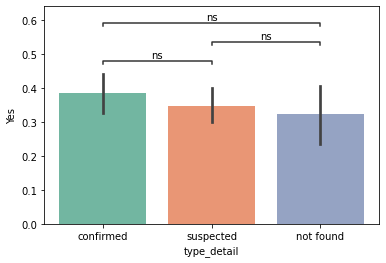

In [268]:
plot_df = (
    table_df
    .groupby(["type_detail", "type"])["response"]
    .value_counts(normalize=True)
    .unstack()
    .drop("No", axis=1)
    .reset_index()
)

ax=sns.barplot(data=plot_df, x="type_detail", y="Yes",order=["confirmed","suspected","not found"],palette="Set2")
ann=Annotator(
            ax, 
            pairs=[("confirmed","not found"),("confirmed","suspected"),("suspected","not found")],
            data=plot_df,
            x="type_detail",
            y="Yes"
        )
ann.configure(test='t-test_ind', text_format='star',loc='inside').apply_and_annotate()
            


## Breakdown of Anxiety and Depression 

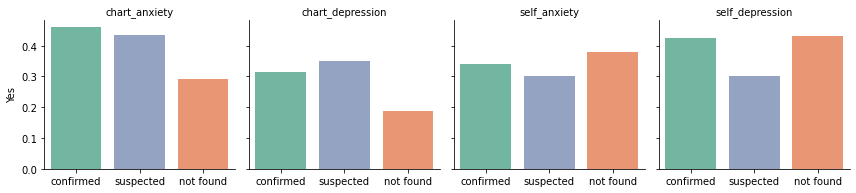

In [266]:
plot = sns.FacetGrid(plot_df, col="type")
plot.map_dataframe(
    sns.barplot,
    x="type_detail",
    y="Yes",
    hue="type_detail",
    palette="Set2",
    order=["confirmed", "suspected", "not found"],
    dodge=False,
)
plot.set_titles("{col_name}")
plot.set_xlabels("")

Combined both patients with confirmed and suspected endometriosis as one group to compare with control

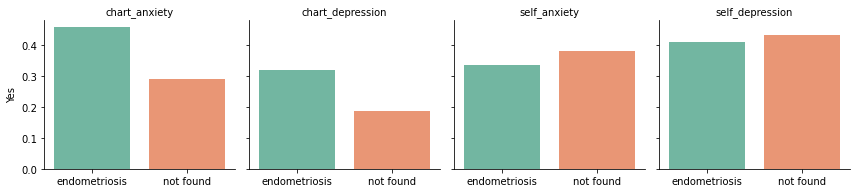

In [267]:
plot_df = (
    table_df.assign(
        type_detail=np.where(
            table_df.type_detail.str.match("confirmed|suspect"),
            "endometriosis",
            "not found",
        )
    )
    .groupby(["type_detail", "type"])["response"]
    .value_counts(normalize=True)
    .unstack()
    .drop("No", axis=1)
    .reset_index()
)


plot = sns.FacetGrid(plot_df, col="type")
plot.map_dataframe(
    sns.barplot,
    x="type_detail",
    y="Yes",
    hue="type_detail",
    palette="Set2",
    order=["endometriosis", "not found"],
    dodge=False,
)
plot.set_titles("{col_name}")
plot.set_xlabels("")

## Comparison between self-report and chart review 
There is a discrepancy between self-report and chart review anxiety/depression. Particularly, 153 patients self-report to have both anxiety and depression but not found in their medical charts. It highlights the need to differentiate the source of the data which may lead to a different conclusion. Further studies are need to examine and address the discrepancy      

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7f25d2d05810>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7f25ec526ed0>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7f25ecf2c6d0>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7f25d2d4fe50>}

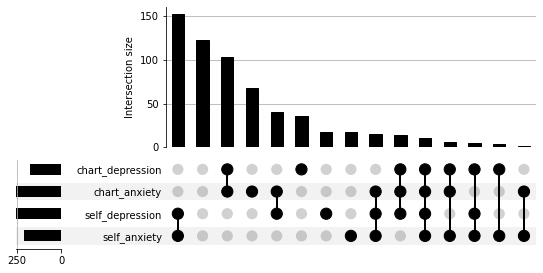

In [324]:
table_df[["self_anxiety", "self_depression", "chart_anxiety", "chart_depression"]] = (
    table_df[
        ["self_anxiety", "self_depression", "chart_anxiety", "chart_depression"]
    ].applymap(lambda x: True if x == "Yes" else False)
)
up_plot = table_df.groupby(
    ["self_anxiety", "self_depression", "chart_anxiety", "chart_depression"]
).size()

UpSet(up_plot, sort_by="cardinality", sort_categories_by="input").plot()
# from_memberships(table_df)